# 回归问题

根据汽车属性参数预测油耗，可应用场景：预测气温、机器翻译、智能问答

## 1. 导入包，并打印版本信息

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

boston_housing = tf.keras.datasets.boston_housing
models = tf.keras.models
layers = tf.keras.layers
activations = tf.keras.activations
optimizers = tf.keras.optimizers
losses = tf.keras.losses

print('tensorflow: ' + tf.__version__)
print('pandas: ' + pd.__version__)
print('numpy: ' + np.__version__)
print('matplotlib: ' + matplotlib.__version__)
print('seaborn: ' + sns.__version__)

tensorflow: 1.14.0
pandas: 0.25.0
numpy: 1.16.4
matplotlib: 3.1.0
seaborn: 0.9.0


## 2. 准备样本数据
汽车数据

| 栏位           | 说明                    |
| :-------------------| :--------------------------------|
| MPG            | 油耗， 需要预测的数据        |
| Cylinders        | 汽缸数                  |
| Displacement      | 排量                    |
| Horsepower       | 马力                    |
| Weight          | 总量                    |
| Acceleration      | 加速度                  |
| Model Year       | 生产年份                 |
| Origin          | 产地， 1: 美国，2: 欧洲，3: 日本 |


In [2]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t',sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## 3. 预处理数据

### 3.1 清理无效数据

#### 3.1.1 查看无效数据

In [3]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

#### 3.1.2 清理无效数据

In [4]:
dataset = dataset.dropna()

#### 3.1.3 再来看一下

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

### 3.2 处理类别栏位
`Origin`栏位通过值1，2，3来标识产地，这里把它转换成One-Hot模式，注意下面的输出，`Origin`栏位被移除，增加 `USA`、`Europe`、`Japan` 3个栏位

In [6]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### 3.3 将数据分离成训练集和测试集

In [7]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print('dataset.shape: ' + str(dataset.shape))
print('train_dataset.shape: ' + str(train_dataset.shape))
print('test_dataset.shape： ' + str(test_dataset.shape))

dataset.shape: (392, 10)
train_dataset.shape: (314, 10)
test_dataset.shape： (78, 10)


### 3.4 看一下数据分布
通俗一点：看点是不是能聚在一起
[seaborn.pairplot文档说明](https://seaborn.pydata.org/generated/seaborn.pairplot.html#seaborn.pairplot)

#### 3.4.1 用图来查看数据分布

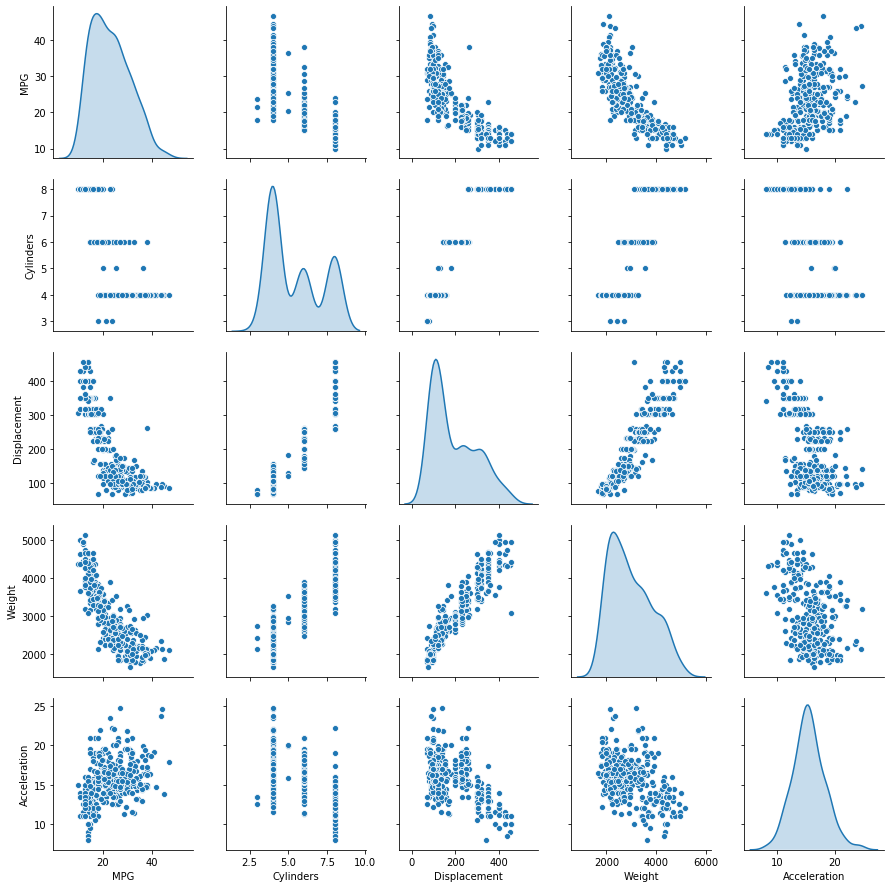

In [8]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight", "Acceleration"]], diag_kind="kde")
plt.show()

#### 3.4.2 使用Pandas查看数据分布

In [9]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
print(train_stats)

              count         mean         std     min      25%     50%  \
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   

                  75%     max  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acceleration    17.20    24.8  
Model Year      79.00    82.0  
USA              1.00     1.0  
Europe       

### 3.5 分别从训练数据和测试数据中分理出标签数据

In [10]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### 3.6 数据标准化
NOTE: std决定是不是需要标准化，这里使用Pandas处理，也可以使用numpy处理
```python
normed_train_data = train_dataset.to_numpy()
mean = normed_train_data.mean(axis=0)
normed_train_data -= mean
std = normed_train_data.std(axis=0)
normed_train_data /= std

normed_test_data = test_dataset.to_numpy()
normed_test_data -=mean
normed_test_data /=std

```

In [11]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

### 3.7 再来看一下标准化后的数据

In [12]:
train_stats = normed_train_data.describe()
train_stats = train_stats.transpose()
print(train_stats)

              count          mean  std       min       25%       50%  \
Cylinders     314.0  1.824443e-16  1.0 -1.457657 -0.869348 -0.869348   
Displacement  314.0  8.627211e-17  1.0 -1.220325 -0.860894 -0.424785   
Horsepower    314.0 -9.900078e-18  1.0 -1.545283 -0.751241 -0.272190   
Weight        314.0 -8.485781e-17  1.0 -1.589352 -0.869478 -0.198782   
Acceleration  314.0 -5.148041e-16  1.0 -2.710152 -0.630725 -0.021237   
Model Year    314.0  9.772791e-16  1.0 -1.604642 -0.788458  0.027726   
USA           314.0  7.920062e-17  1.0 -1.286751 -1.286751  0.774676   
Europe        314.0  1.980016e-17  1.0 -0.465148 -0.465148 -0.465148   
Japan         314.0  5.374328e-17  1.0 -0.495225 -0.495225 -0.495225   

                   75%       max  
Cylinders     1.483887  1.483887  
Displacement  0.675074  2.489002  
Horsepower    0.607162  3.153347  
Weight        0.732017  2.547401  
Acceleration  0.588250  3.313017  
Model Year    0.843910  1.660094  
USA           0.774676  0.774676  

## 4.  创建模型

In [13]:
model = models.Sequential(
    [
        layers.Dense(64, activation=activations.relu, input_shape=(normed_train_data.shape[1],)),
        layers.Dense(64, activation=activations.relu),
        layers.Dense(1)
    ]
)

model.compile(
    loss=losses.mean_squared_error,
    optimizer=optimizers.RMSprop(0.001),
    metrics=['mean_absolute_error', 'mean_squared_error']
)

model.summary()


W0726 05:23:43.496720 140518200964928 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


## 5. 训练模型

In [14]:
history = model.fit(
    normed_train_data,
    train_labels,
    epochs=1000, 
    validation_split = 0.2
)

Train on 251 samples, validate on 63 samples
Epoch 1/1000
251/251 [==============================] - 0s 347us/sample - loss: 567.9389 - mean_absolute_error: 22.5602 - mean_squared_error: 567.9388 - val_loss: 559.1056 - val_mean_absolute_error: 22.3170 - val_mean_squared_error: 559.1057
Epoch 2/1000
251/251 [==============================] - 0s 33us/sample - loss: 516.4081 - mean_absolute_error: 21.3687 - mean_squared_error: 516.4081 - val_loss: 507.2135 - val_mean_absolute_error: 21.1082 - val_mean_squared_error: 507.2135
Epoch 3/1000
251/251 [==============================] - 0s 33us/sample - loss: 465.9970 - mean_absolute_error: 20.1636 - mean_squared_error: 465.9970 - val_loss: 449.9968 - val_mean_absolute_error: 19.7226 - val_mean_squared_error: 449.9968
Epoch 4/1000
251/251 [==============================] - 0s 42us/sample - loss: 410.7349 - mean_absolute_error: 18.7602 - mean_squared_error: 410.7349 - val_loss: 387.6897 - val_mean_absolute_error: 18.1358 - val_mean_squared_error:

251/251 [==============================] - 0s 33us/sample - loss: 7.7001 - mean_absolute_error: 1.9418 - mean_squared_error: 7.7001 - val_loss: 9.0736 - val_mean_absolute_error: 2.3470 - val_mean_squared_error: 9.0736
Epoch 36/1000
251/251 [==============================] - 0s 32us/sample - loss: 7.5110 - mean_absolute_error: 1.9552 - mean_squared_error: 7.5110 - val_loss: 9.2322 - val_mean_absolute_error: 2.2312 - val_mean_squared_error: 9.2322
Epoch 37/1000
251/251 [==============================] - 0s 32us/sample - loss: 7.6389 - mean_absolute_error: 1.9483 - mean_squared_error: 7.6389 - val_loss: 9.0699 - val_mean_absolute_error: 2.2291 - val_mean_squared_error: 9.0699
Epoch 38/1000
251/251 [==============================] - 0s 32us/sample - loss: 7.5518 - mean_absolute_error: 1.9455 - mean_squared_error: 7.5518 - val_loss: 8.8567 - val_mean_absolute_error: 2.3085 - val_mean_squared_error: 8.8567
Epoch 39/1000
251/251 [==============================] - 0s 32us/sample - loss: 7.2219

251/251 [==============================] - 0s 33us/sample - loss: 6.2527 - mean_absolute_error: 1.7987 - mean_squared_error: 6.2527 - val_loss: 8.5540 - val_mean_absolute_error: 2.2750 - val_mean_squared_error: 8.5540
Epoch 71/1000
251/251 [==============================] - 0s 32us/sample - loss: 6.1829 - mean_absolute_error: 1.7420 - mean_squared_error: 6.1829 - val_loss: 8.5473 - val_mean_absolute_error: 2.2004 - val_mean_squared_error: 8.5473
Epoch 72/1000
251/251 [==============================] - 0s 33us/sample - loss: 6.2717 - mean_absolute_error: 1.7652 - mean_squared_error: 6.2717 - val_loss: 8.8098 - val_mean_absolute_error: 2.1396 - val_mean_squared_error: 8.8098
Epoch 73/1000
251/251 [==============================] - 0s 32us/sample - loss: 6.2216 - mean_absolute_error: 1.7726 - mean_squared_error: 6.2216 - val_loss: 8.4784 - val_mean_absolute_error: 2.1836 - val_mean_squared_error: 8.4784
Epoch 74/1000
251/251 [==============================] - 0s 33us/sample - loss: 6.1005

251/251 [==============================] - 0s 33us/sample - loss: 5.7052 - mean_absolute_error: 1.6830 - mean_squared_error: 5.7052 - val_loss: 8.2589 - val_mean_absolute_error: 2.2184 - val_mean_squared_error: 8.2589
Epoch 106/1000
251/251 [==============================] - 0s 33us/sample - loss: 5.7002 - mean_absolute_error: 1.6760 - mean_squared_error: 5.7002 - val_loss: 8.7118 - val_mean_absolute_error: 2.3171 - val_mean_squared_error: 8.7118
Epoch 107/1000
251/251 [==============================] - 0s 33us/sample - loss: 5.6996 - mean_absolute_error: 1.6567 - mean_squared_error: 5.6996 - val_loss: 8.4105 - val_mean_absolute_error: 2.1025 - val_mean_squared_error: 8.4105
Epoch 108/1000
251/251 [==============================] - 0s 33us/sample - loss: 5.8354 - mean_absolute_error: 1.6916 - mean_squared_error: 5.8354 - val_loss: 8.1992 - val_mean_absolute_error: 2.1268 - val_mean_squared_error: 8.1992
Epoch 109/1000
251/251 [==============================] - 0s 32us/sample - loss: 5.

251/251 [==============================] - 0s 32us/sample - loss: 5.5203 - mean_absolute_error: 1.6306 - mean_squared_error: 5.5203 - val_loss: 8.3524 - val_mean_absolute_error: 2.2221 - val_mean_squared_error: 8.3524
Epoch 141/1000
251/251 [==============================] - 0s 32us/sample - loss: 5.4971 - mean_absolute_error: 1.6476 - mean_squared_error: 5.4971 - val_loss: 8.5034 - val_mean_absolute_error: 2.2486 - val_mean_squared_error: 8.5034
Epoch 142/1000
251/251 [==============================] - 0s 33us/sample - loss: 5.3993 - mean_absolute_error: 1.6260 - mean_squared_error: 5.3993 - val_loss: 8.5890 - val_mean_absolute_error: 2.2625 - val_mean_squared_error: 8.5890
Epoch 143/1000
251/251 [==============================] - 0s 32us/sample - loss: 5.3435 - mean_absolute_error: 1.6049 - mean_squared_error: 5.3435 - val_loss: 8.1039 - val_mean_absolute_error: 2.1217 - val_mean_squared_error: 8.1039
Epoch 144/1000
251/251 [==============================] - 0s 32us/sample - loss: 5.

251/251 [==============================] - 0s 32us/sample - loss: 5.2580 - mean_absolute_error: 1.5819 - mean_squared_error: 5.2580 - val_loss: 8.1361 - val_mean_absolute_error: 2.1724 - val_mean_squared_error: 8.1361
Epoch 176/1000
251/251 [==============================] - 0s 37us/sample - loss: 5.2323 - mean_absolute_error: 1.5783 - mean_squared_error: 5.2323 - val_loss: 8.5257 - val_mean_absolute_error: 2.1604 - val_mean_squared_error: 8.5257
Epoch 177/1000
251/251 [==============================] - 0s 32us/sample - loss: 5.2309 - mean_absolute_error: 1.5935 - mean_squared_error: 5.2309 - val_loss: 8.1461 - val_mean_absolute_error: 2.1751 - val_mean_squared_error: 8.1461
Epoch 178/1000
251/251 [==============================] - 0s 33us/sample - loss: 5.3886 - mean_absolute_error: 1.5957 - mean_squared_error: 5.3886 - val_loss: 8.3780 - val_mean_absolute_error: 2.2080 - val_mean_squared_error: 8.3780
Epoch 179/1000
251/251 [==============================] - 0s 32us/sample - loss: 5.

251/251 [==============================] - 0s 32us/sample - loss: 5.0121 - mean_absolute_error: 1.5189 - mean_squared_error: 5.0121 - val_loss: 8.1000 - val_mean_absolute_error: 2.1488 - val_mean_squared_error: 8.1000
Epoch 211/1000
251/251 [==============================] - 0s 32us/sample - loss: 5.1356 - mean_absolute_error: 1.5541 - mean_squared_error: 5.1356 - val_loss: 8.0798 - val_mean_absolute_error: 2.1258 - val_mean_squared_error: 8.0798
Epoch 212/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.9537 - mean_absolute_error: 1.5939 - mean_squared_error: 4.9537 - val_loss: 8.7287 - val_mean_absolute_error: 2.2840 - val_mean_squared_error: 8.7287
Epoch 213/1000
251/251 [==============================] - 0s 32us/sample - loss: 5.0430 - mean_absolute_error: 1.5327 - mean_squared_error: 5.0430 - val_loss: 8.1330 - val_mean_absolute_error: 2.1763 - val_mean_squared_error: 8.1330
Epoch 214/1000
251/251 [==============================] - 0s 37us/sample - loss: 5.

251/251 [==============================] - 0s 33us/sample - loss: 5.0751 - mean_absolute_error: 1.5593 - mean_squared_error: 5.0751 - val_loss: 8.1405 - val_mean_absolute_error: 2.1847 - val_mean_squared_error: 8.1405
Epoch 246/1000
251/251 [==============================] - 0s 32us/sample - loss: 4.9051 - mean_absolute_error: 1.4996 - mean_squared_error: 4.9051 - val_loss: 8.5655 - val_mean_absolute_error: 2.2520 - val_mean_squared_error: 8.5655
Epoch 247/1000
251/251 [==============================] - 0s 32us/sample - loss: 4.8287 - mean_absolute_error: 1.5097 - mean_squared_error: 4.8287 - val_loss: 8.5590 - val_mean_absolute_error: 2.2601 - val_mean_squared_error: 8.5590
Epoch 248/1000
251/251 [==============================] - 0s 32us/sample - loss: 5.1164 - mean_absolute_error: 1.4988 - mean_squared_error: 5.1164 - val_loss: 8.1115 - val_mean_absolute_error: 2.1683 - val_mean_squared_error: 8.1115
Epoch 249/1000
251/251 [==============================] - 0s 32us/sample - loss: 4.

251/251 [==============================] - 0s 32us/sample - loss: 4.8280 - mean_absolute_error: 1.4851 - mean_squared_error: 4.8280 - val_loss: 8.2638 - val_mean_absolute_error: 2.1783 - val_mean_squared_error: 8.2638
Epoch 281/1000
251/251 [==============================] - 0s 32us/sample - loss: 4.7193 - mean_absolute_error: 1.4793 - mean_squared_error: 4.7193 - val_loss: 8.5369 - val_mean_absolute_error: 2.2693 - val_mean_squared_error: 8.5369
Epoch 282/1000
251/251 [==============================] - 0s 32us/sample - loss: 4.7966 - mean_absolute_error: 1.4750 - mean_squared_error: 4.7966 - val_loss: 8.4612 - val_mean_absolute_error: 2.2341 - val_mean_squared_error: 8.4612
Epoch 283/1000
251/251 [==============================] - 0s 41us/sample - loss: 4.7972 - mean_absolute_error: 1.4903 - mean_squared_error: 4.7972 - val_loss: 8.4120 - val_mean_absolute_error: 2.2299 - val_mean_squared_error: 8.4120
Epoch 284/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.

251/251 [==============================] - 0s 34us/sample - loss: 4.5340 - mean_absolute_error: 1.4456 - mean_squared_error: 4.5340 - val_loss: 8.2464 - val_mean_absolute_error: 2.1737 - val_mean_squared_error: 8.2464
Epoch 316/1000
251/251 [==============================] - 0s 34us/sample - loss: 4.5101 - mean_absolute_error: 1.4648 - mean_squared_error: 4.5101 - val_loss: 8.2860 - val_mean_absolute_error: 2.2102 - val_mean_squared_error: 8.2860
Epoch 317/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.7074 - mean_absolute_error: 1.4626 - mean_squared_error: 4.7074 - val_loss: 8.2237 - val_mean_absolute_error: 2.1972 - val_mean_squared_error: 8.2237
Epoch 318/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.7253 - mean_absolute_error: 1.4683 - mean_squared_error: 4.7253 - val_loss: 8.1935 - val_mean_absolute_error: 2.1575 - val_mean_squared_error: 8.1935
Epoch 319/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.

251/251 [==============================] - 0s 33us/sample - loss: 4.4601 - mean_absolute_error: 1.4193 - mean_squared_error: 4.4601 - val_loss: 8.4947 - val_mean_absolute_error: 2.1980 - val_mean_squared_error: 8.4947
Epoch 351/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.5633 - mean_absolute_error: 1.4734 - mean_squared_error: 4.5633 - val_loss: 8.4583 - val_mean_absolute_error: 2.2476 - val_mean_squared_error: 8.4583
Epoch 352/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.6877 - mean_absolute_error: 1.4647 - mean_squared_error: 4.6877 - val_loss: 8.0762 - val_mean_absolute_error: 2.1850 - val_mean_squared_error: 8.0762
Epoch 353/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.6557 - mean_absolute_error: 1.4517 - mean_squared_error: 4.6557 - val_loss: 8.3886 - val_mean_absolute_error: 2.2429 - val_mean_squared_error: 8.3886
Epoch 354/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.

251/251 [==============================] - 0s 32us/sample - loss: 4.3570 - mean_absolute_error: 1.4274 - mean_squared_error: 4.3570 - val_loss: 8.3576 - val_mean_absolute_error: 2.1981 - val_mean_squared_error: 8.3576
Epoch 386/1000
251/251 [==============================] - 0s 32us/sample - loss: 4.4960 - mean_absolute_error: 1.4349 - mean_squared_error: 4.4960 - val_loss: 8.1846 - val_mean_absolute_error: 2.1882 - val_mean_squared_error: 8.1846
Epoch 387/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.4517 - mean_absolute_error: 1.4440 - mean_squared_error: 4.4517 - val_loss: 8.0392 - val_mean_absolute_error: 2.1875 - val_mean_squared_error: 8.0392
Epoch 388/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.3823 - mean_absolute_error: 1.4133 - mean_squared_error: 4.3823 - val_loss: 8.0892 - val_mean_absolute_error: 2.2001 - val_mean_squared_error: 8.0892
Epoch 389/1000
251/251 [==============================] - 0s 32us/sample - loss: 4.

251/251 [==============================] - 0s 33us/sample - loss: 4.3709 - mean_absolute_error: 1.4197 - mean_squared_error: 4.3709 - val_loss: 8.3686 - val_mean_absolute_error: 2.2078 - val_mean_squared_error: 8.3686
Epoch 421/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.2373 - mean_absolute_error: 1.4168 - mean_squared_error: 4.2373 - val_loss: 8.6136 - val_mean_absolute_error: 2.2576 - val_mean_squared_error: 8.6136
Epoch 422/1000
251/251 [==============================] - 0s 32us/sample - loss: 4.3583 - mean_absolute_error: 1.4097 - mean_squared_error: 4.3583 - val_loss: 8.3818 - val_mean_absolute_error: 2.1786 - val_mean_squared_error: 8.3818
Epoch 423/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.2607 - mean_absolute_error: 1.4242 - mean_squared_error: 4.2607 - val_loss: 8.7293 - val_mean_absolute_error: 2.2811 - val_mean_squared_error: 8.7293
Epoch 424/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.

251/251 [==============================] - 0s 33us/sample - loss: 4.2498 - mean_absolute_error: 1.4071 - mean_squared_error: 4.2498 - val_loss: 8.4473 - val_mean_absolute_error: 2.2255 - val_mean_squared_error: 8.4473
Epoch 456/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.2316 - mean_absolute_error: 1.3653 - mean_squared_error: 4.2316 - val_loss: 8.5132 - val_mean_absolute_error: 2.2120 - val_mean_squared_error: 8.5132
Epoch 457/1000
251/251 [==============================] - 0s 32us/sample - loss: 4.2831 - mean_absolute_error: 1.3910 - mean_squared_error: 4.2831 - val_loss: 8.3294 - val_mean_absolute_error: 2.1973 - val_mean_squared_error: 8.3294
Epoch 458/1000
251/251 [==============================] - 0s 34us/sample - loss: 4.1133 - mean_absolute_error: 1.3707 - mean_squared_error: 4.1133 - val_loss: 8.5067 - val_mean_absolute_error: 2.2497 - val_mean_squared_error: 8.5067
Epoch 459/1000
251/251 [==============================] - 0s 34us/sample - loss: 4.

251/251 [==============================] - 0s 33us/sample - loss: 4.2600 - mean_absolute_error: 1.3914 - mean_squared_error: 4.2600 - val_loss: 8.8416 - val_mean_absolute_error: 2.2268 - val_mean_squared_error: 8.8416
Epoch 491/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.2521 - mean_absolute_error: 1.3912 - mean_squared_error: 4.2521 - val_loss: 8.5936 - val_mean_absolute_error: 2.2586 - val_mean_squared_error: 8.5936
Epoch 492/1000
251/251 [==============================] - 0s 32us/sample - loss: 3.9506 - mean_absolute_error: 1.3225 - mean_squared_error: 3.9506 - val_loss: 8.1741 - val_mean_absolute_error: 2.1713 - val_mean_squared_error: 8.1741
Epoch 493/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.0811 - mean_absolute_error: 1.3677 - mean_squared_error: 4.0811 - val_loss: 8.5799 - val_mean_absolute_error: 2.2626 - val_mean_squared_error: 8.5799
Epoch 494/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.

251/251 [==============================] - 0s 32us/sample - loss: 4.0612 - mean_absolute_error: 1.3812 - mean_squared_error: 4.0612 - val_loss: 9.0758 - val_mean_absolute_error: 2.3210 - val_mean_squared_error: 9.0758
Epoch 526/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.9416 - mean_absolute_error: 1.3236 - mean_squared_error: 3.9416 - val_loss: 8.8513 - val_mean_absolute_error: 2.2961 - val_mean_squared_error: 8.8513
Epoch 527/1000
251/251 [==============================] - 0s 34us/sample - loss: 3.8708 - mean_absolute_error: 1.3167 - mean_squared_error: 3.8708 - val_loss: 8.4828 - val_mean_absolute_error: 2.2450 - val_mean_squared_error: 8.4828
Epoch 528/1000
251/251 [==============================] - 0s 32us/sample - loss: 4.0541 - mean_absolute_error: 1.3536 - mean_squared_error: 4.0541 - val_loss: 8.4240 - val_mean_absolute_error: 2.2227 - val_mean_squared_error: 8.4240
Epoch 529/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.

251/251 [==============================] - 0s 32us/sample - loss: 3.9452 - mean_absolute_error: 1.3590 - mean_squared_error: 3.9452 - val_loss: 8.7392 - val_mean_absolute_error: 2.2758 - val_mean_squared_error: 8.7392
Epoch 561/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.9274 - mean_absolute_error: 1.3484 - mean_squared_error: 3.9274 - val_loss: 8.9445 - val_mean_absolute_error: 2.2998 - val_mean_squared_error: 8.9445
Epoch 562/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.9498 - mean_absolute_error: 1.3272 - mean_squared_error: 3.9498 - val_loss: 8.4703 - val_mean_absolute_error: 2.2376 - val_mean_squared_error: 8.4703
Epoch 563/1000
251/251 [==============================] - 0s 32us/sample - loss: 4.0054 - mean_absolute_error: 1.3530 - mean_squared_error: 4.0054 - val_loss: 8.4039 - val_mean_absolute_error: 2.2018 - val_mean_squared_error: 8.4039
Epoch 564/1000
251/251 [==============================] - 0s 33us/sample - loss: 4.

251/251 [==============================] - 0s 33us/sample - loss: 4.0206 - mean_absolute_error: 1.3338 - mean_squared_error: 4.0206 - val_loss: 8.5365 - val_mean_absolute_error: 2.2294 - val_mean_squared_error: 8.5365
Epoch 596/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.8314 - mean_absolute_error: 1.3132 - mean_squared_error: 3.8314 - val_loss: 8.6724 - val_mean_absolute_error: 2.2667 - val_mean_squared_error: 8.6724
Epoch 597/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.8624 - mean_absolute_error: 1.3018 - mean_squared_error: 3.8624 - val_loss: 8.5321 - val_mean_absolute_error: 2.2165 - val_mean_squared_error: 8.5321
Epoch 598/1000
251/251 [==============================] - 0s 36us/sample - loss: 3.8279 - mean_absolute_error: 1.2732 - mean_squared_error: 3.8279 - val_loss: 8.5327 - val_mean_absolute_error: 2.2344 - val_mean_squared_error: 8.5327
Epoch 599/1000
251/251 [==============================] - 0s 34us/sample - loss: 3.

251/251 [==============================] - 0s 33us/sample - loss: 3.8254 - mean_absolute_error: 1.3312 - mean_squared_error: 3.8254 - val_loss: 8.7471 - val_mean_absolute_error: 2.2989 - val_mean_squared_error: 8.7471
Epoch 631/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.8363 - mean_absolute_error: 1.3011 - mean_squared_error: 3.8363 - val_loss: 8.7318 - val_mean_absolute_error: 2.2582 - val_mean_squared_error: 8.7318
Epoch 632/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.7335 - mean_absolute_error: 1.2955 - mean_squared_error: 3.7335 - val_loss: 8.8057 - val_mean_absolute_error: 2.2540 - val_mean_squared_error: 8.8057
Epoch 633/1000
251/251 [==============================] - 0s 34us/sample - loss: 3.8151 - mean_absolute_error: 1.3101 - mean_squared_error: 3.8151 - val_loss: 8.5170 - val_mean_absolute_error: 2.2413 - val_mean_squared_error: 8.5170
Epoch 634/1000
251/251 [==============================] - 0s 34us/sample - loss: 3.

251/251 [==============================] - 0s 33us/sample - loss: 3.8591 - mean_absolute_error: 1.3029 - mean_squared_error: 3.8591 - val_loss: 8.9495 - val_mean_absolute_error: 2.3068 - val_mean_squared_error: 8.9495
Epoch 666/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.5507 - mean_absolute_error: 1.2425 - mean_squared_error: 3.5507 - val_loss: 8.9448 - val_mean_absolute_error: 2.2658 - val_mean_squared_error: 8.9448
Epoch 667/1000
251/251 [==============================] - 0s 34us/sample - loss: 3.7152 - mean_absolute_error: 1.3046 - mean_squared_error: 3.7152 - val_loss: 8.9801 - val_mean_absolute_error: 2.3101 - val_mean_squared_error: 8.9801
Epoch 668/1000
251/251 [==============================] - 0s 34us/sample - loss: 3.6718 - mean_absolute_error: 1.3565 - mean_squared_error: 3.6718 - val_loss: 9.4651 - val_mean_absolute_error: 2.3677 - val_mean_squared_error: 9.4651
Epoch 669/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.

251/251 [==============================] - 0s 33us/sample - loss: 3.6679 - mean_absolute_error: 1.2424 - mean_squared_error: 3.6679 - val_loss: 9.0274 - val_mean_absolute_error: 2.3179 - val_mean_squared_error: 9.0274
Epoch 701/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.5035 - mean_absolute_error: 1.2390 - mean_squared_error: 3.5035 - val_loss: 8.5365 - val_mean_absolute_error: 2.2419 - val_mean_squared_error: 8.5365
Epoch 702/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.5504 - mean_absolute_error: 1.2664 - mean_squared_error: 3.5504 - val_loss: 9.2646 - val_mean_absolute_error: 2.3357 - val_mean_squared_error: 9.2646
Epoch 703/1000
251/251 [==============================] - 0s 32us/sample - loss: 3.5411 - mean_absolute_error: 1.2398 - mean_squared_error: 3.5411 - val_loss: 9.0038 - val_mean_absolute_error: 2.3135 - val_mean_squared_error: 9.0038
Epoch 704/1000
251/251 [==============================] - 0s 32us/sample - loss: 3.

251/251 [==============================] - 0s 33us/sample - loss: 3.4110 - mean_absolute_error: 1.2352 - mean_squared_error: 3.4110 - val_loss: 9.0080 - val_mean_absolute_error: 2.2891 - val_mean_squared_error: 9.0080
Epoch 736/1000
251/251 [==============================] - 0s 34us/sample - loss: 3.4235 - mean_absolute_error: 1.2402 - mean_squared_error: 3.4235 - val_loss: 8.9302 - val_mean_absolute_error: 2.2904 - val_mean_squared_error: 8.9302
Epoch 737/1000
251/251 [==============================] - 0s 34us/sample - loss: 3.5598 - mean_absolute_error: 1.2896 - mean_squared_error: 3.5598 - val_loss: 8.8752 - val_mean_absolute_error: 2.3017 - val_mean_squared_error: 8.8752
Epoch 738/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.5290 - mean_absolute_error: 1.2329 - mean_squared_error: 3.5290 - val_loss: 9.1044 - val_mean_absolute_error: 2.3163 - val_mean_squared_error: 9.1044
Epoch 739/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.

251/251 [==============================] - 0s 33us/sample - loss: 3.5736 - mean_absolute_error: 1.2519 - mean_squared_error: 3.5736 - val_loss: 9.6007 - val_mean_absolute_error: 2.3757 - val_mean_squared_error: 9.6007
Epoch 771/1000
251/251 [==============================] - 0s 34us/sample - loss: 3.4886 - mean_absolute_error: 1.2502 - mean_squared_error: 3.4886 - val_loss: 9.6156 - val_mean_absolute_error: 2.3924 - val_mean_squared_error: 9.6156
Epoch 772/1000
251/251 [==============================] - 0s 34us/sample - loss: 3.4000 - mean_absolute_error: 1.1799 - mean_squared_error: 3.4000 - val_loss: 9.1285 - val_mean_absolute_error: 2.3034 - val_mean_squared_error: 9.1285
Epoch 773/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.3453 - mean_absolute_error: 1.2353 - mean_squared_error: 3.3453 - val_loss: 9.2583 - val_mean_absolute_error: 2.3517 - val_mean_squared_error: 9.2583
Epoch 774/1000
251/251 [==============================] - 0s 35us/sample - loss: 3.

251/251 [==============================] - 0s 34us/sample - loss: 3.3662 - mean_absolute_error: 1.2314 - mean_squared_error: 3.3662 - val_loss: 9.7961 - val_mean_absolute_error: 2.3936 - val_mean_squared_error: 9.7961
Epoch 806/1000
251/251 [==============================] - 0s 32us/sample - loss: 3.3039 - mean_absolute_error: 1.1959 - mean_squared_error: 3.3039 - val_loss: 9.8060 - val_mean_absolute_error: 2.3866 - val_mean_squared_error: 9.8060
Epoch 807/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.3185 - mean_absolute_error: 1.2038 - mean_squared_error: 3.3185 - val_loss: 9.2741 - val_mean_absolute_error: 2.3401 - val_mean_squared_error: 9.2741
Epoch 808/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.3211 - mean_absolute_error: 1.1883 - mean_squared_error: 3.3211 - val_loss: 9.4391 - val_mean_absolute_error: 2.3329 - val_mean_squared_error: 9.4391
Epoch 809/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.

251/251 [==============================] - 0s 33us/sample - loss: 3.1342 - mean_absolute_error: 1.1442 - mean_squared_error: 3.1342 - val_loss: 9.7164 - val_mean_absolute_error: 2.3816 - val_mean_squared_error: 9.7164
Epoch 841/1000
251/251 [==============================] - 0s 38us/sample - loss: 3.1913 - mean_absolute_error: 1.1569 - mean_squared_error: 3.1913 - val_loss: 9.8422 - val_mean_absolute_error: 2.3812 - val_mean_squared_error: 9.8422
Epoch 842/1000
251/251 [==============================] - 0s 34us/sample - loss: 3.1246 - mean_absolute_error: 1.2006 - mean_squared_error: 3.1246 - val_loss: 9.9748 - val_mean_absolute_error: 2.4446 - val_mean_squared_error: 9.9748
Epoch 843/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.2406 - mean_absolute_error: 1.1793 - mean_squared_error: 3.2406 - val_loss: 9.8521 - val_mean_absolute_error: 2.4026 - val_mean_squared_error: 9.8521
Epoch 844/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.

251/251 [==============================] - 0s 33us/sample - loss: 3.2066 - mean_absolute_error: 1.1832 - mean_squared_error: 3.2066 - val_loss: 9.7713 - val_mean_absolute_error: 2.3913 - val_mean_squared_error: 9.7713
Epoch 876/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.0604 - mean_absolute_error: 1.1472 - mean_squared_error: 3.0604 - val_loss: 10.2099 - val_mean_absolute_error: 2.4474 - val_mean_squared_error: 10.2099
Epoch 877/1000
251/251 [==============================] - 0s 37us/sample - loss: 3.2293 - mean_absolute_error: 1.1818 - mean_squared_error: 3.2293 - val_loss: 9.8799 - val_mean_absolute_error: 2.3884 - val_mean_squared_error: 9.8799
Epoch 878/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.2014 - mean_absolute_error: 1.1928 - mean_squared_error: 3.2014 - val_loss: 9.7112 - val_mean_absolute_error: 2.3848 - val_mean_squared_error: 9.7112
Epoch 879/1000
251/251 [==============================] - 0s 37us/sample - loss: 

251/251 [==============================] - 0s 33us/sample - loss: 3.0058 - mean_absolute_error: 1.1098 - mean_squared_error: 3.0058 - val_loss: 10.1082 - val_mean_absolute_error: 2.3980 - val_mean_squared_error: 10.1082
Epoch 911/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.2164 - mean_absolute_error: 1.1875 - mean_squared_error: 3.2164 - val_loss: 10.4958 - val_mean_absolute_error: 2.4506 - val_mean_squared_error: 10.4958
Epoch 912/1000
251/251 [==============================] - 0s 33us/sample - loss: 2.9069 - mean_absolute_error: 1.1229 - mean_squared_error: 2.9069 - val_loss: 9.9594 - val_mean_absolute_error: 2.3969 - val_mean_squared_error: 9.9594
Epoch 913/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.1474 - mean_absolute_error: 1.2147 - mean_squared_error: 3.1474 - val_loss: 9.9262 - val_mean_absolute_error: 2.4313 - val_mean_squared_error: 9.9262
Epoch 914/1000
251/251 [==============================] - 0s 33us/sample - loss

251/251 [==============================] - 0s 33us/sample - loss: 2.9101 - mean_absolute_error: 1.1051 - mean_squared_error: 2.9101 - val_loss: 10.1378 - val_mean_absolute_error: 2.4175 - val_mean_squared_error: 10.1378
Epoch 946/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.0597 - mean_absolute_error: 1.2021 - mean_squared_error: 3.0597 - val_loss: 9.6704 - val_mean_absolute_error: 2.3602 - val_mean_squared_error: 9.6704
Epoch 947/1000
251/251 [==============================] - 0s 33us/sample - loss: 2.8393 - mean_absolute_error: 1.0900 - mean_squared_error: 2.8393 - val_loss: 11.9624 - val_mean_absolute_error: 2.6611 - val_mean_squared_error: 11.9624
Epoch 948/1000
251/251 [==============================] - 0s 33us/sample - loss: 3.0179 - mean_absolute_error: 1.1167 - mean_squared_error: 3.0179 - val_loss: 9.5085 - val_mean_absolute_error: 2.3301 - val_mean_squared_error: 9.5085
Epoch 949/1000
251/251 [==============================] - 0s 33us/sample - loss

251/251 [==============================] - 0s 32us/sample - loss: 2.8631 - mean_absolute_error: 1.0743 - mean_squared_error: 2.8631 - val_loss: 10.3863 - val_mean_absolute_error: 2.4285 - val_mean_squared_error: 10.3863
Epoch 981/1000
251/251 [==============================] - 0s 33us/sample - loss: 2.8247 - mean_absolute_error: 1.1010 - mean_squared_error: 2.8247 - val_loss: 9.7714 - val_mean_absolute_error: 2.3794 - val_mean_squared_error: 9.7714
Epoch 982/1000
251/251 [==============================] - 0s 32us/sample - loss: 2.9162 - mean_absolute_error: 1.1169 - mean_squared_error: 2.9162 - val_loss: 9.9841 - val_mean_absolute_error: 2.4517 - val_mean_squared_error: 9.9841
Epoch 983/1000
251/251 [==============================] - 0s 32us/sample - loss: 2.8512 - mean_absolute_error: 1.1140 - mean_squared_error: 2.8512 - val_loss: 10.1069 - val_mean_absolute_error: 2.3910 - val_mean_squared_error: 10.1069
Epoch 984/1000
251/251 [==============================] - 0s 41us/sample - loss

## 6. 查看训练结果

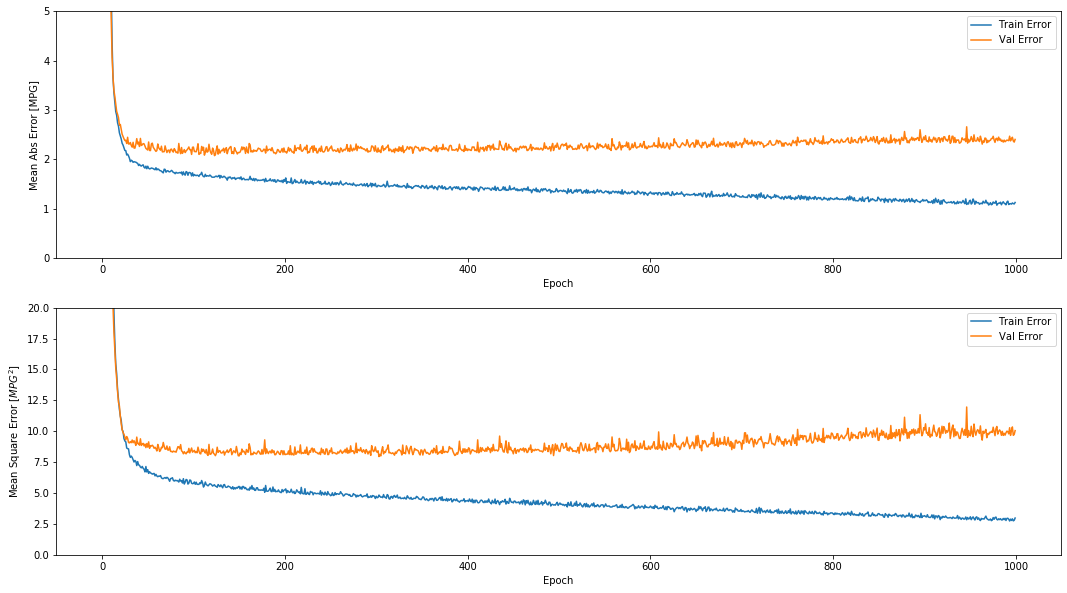

In [15]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(18, 10))
    plt.subplot(2, 1, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'], label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)

## 7. 使用tf.keras.callbacks.EarlyStopping提前终止训练

NOTE: 自动化控制将是深度学习的一个重要发展方向

callbacks参数允许通过编程的方式干预学习过程，比如：
- 当发生过拟合的时候 `提前终止学习`、
- 学习过程分步 `保存模型`

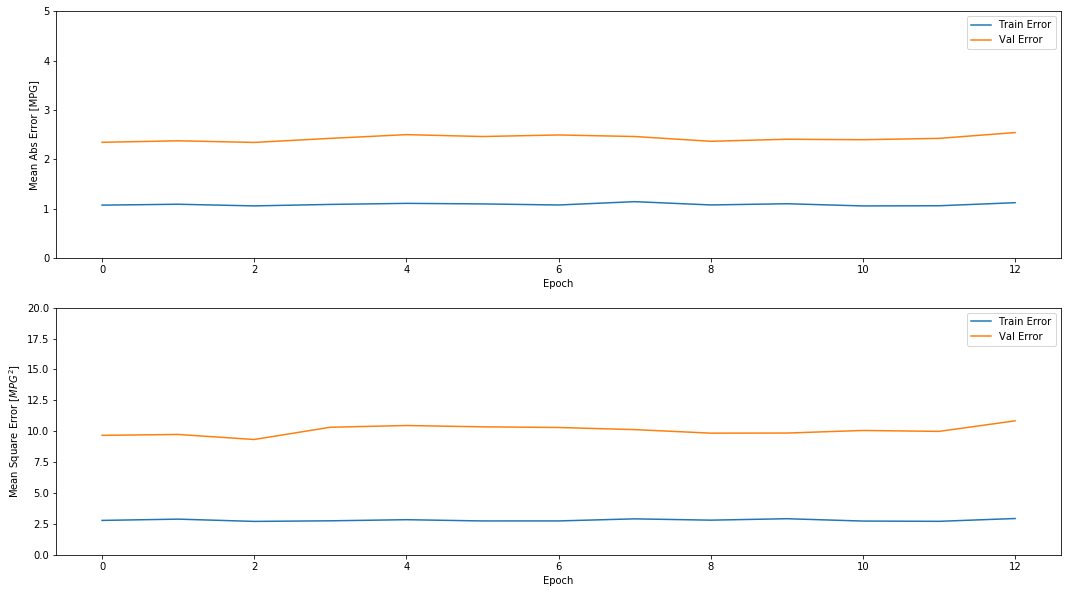

In [16]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(normed_train_data, train_labels, epochs=1000, validation_split = 0.2, verbose=0, callbacks=[early_stop])
plot_history(history)

## 8. 使用测试集评估模型

In [17]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.94 MPG


## 9. 在测试集上使用模型预测结果

使用plt图形化显示误差

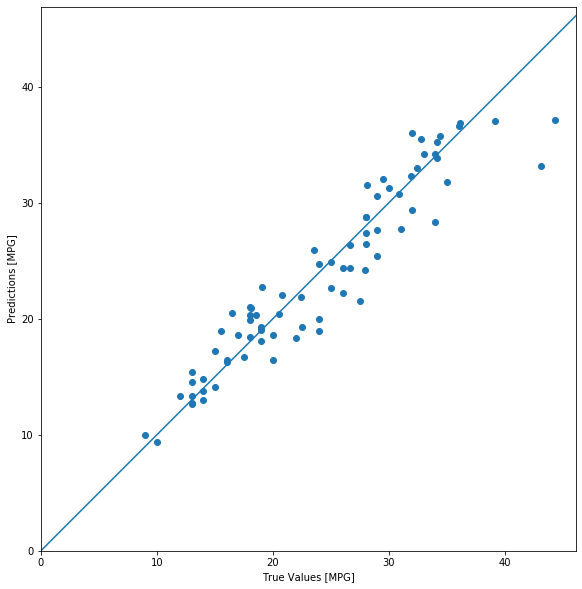

In [18]:
test_predictions = model.predict(normed_test_data).flatten()

plt.figure(figsize=(10, 10))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100])

## 10. 看看误差值是否服从高斯正态分布

NOTE: 扩展一下 6 Sigma

Text(0, 0.5, 'Count')

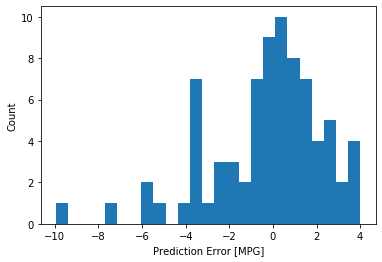

In [19]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")